# TITANIC - KAGGLE PROJECT

https://www.kaggle.com/c/titanic/

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import csv as csv

# Machine Learning imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import learning_curve
from sklearn import grid_search
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

## Get Missing Age Variable: fitting

In [87]:
trainA_df = pd.read_csv('train.csv')
testA_df = pd.read_csv('test.csv')
trainA_df.drop(['Name', 'Ticket', 'Cabin', 'Embarked',
               'PassengerId', 'Survived'], axis=1, inplace=True)
testA_df.drop(['Name', 'Ticket', 'Cabin', 'Embarked',
              'PassengerId'], axis=1, inplace=True)

In [88]:
# Fare
for c in [1, 2, 3]:
    testA_df.loc[(testA_df['Pclass'] == c) & (testA_df['Fare'].isnull()), 'Fare'] = \
    testA_df.loc[(testA_df['Pclass'] == c), 'Fare'].median()

In [89]:
col_names = {'Sex', 'Pclass'}
for name in col_names:
    dummies = pd.get_dummies(testA_df[name])
    testA_df = pd.concat([testA_df, dummies], axis=1)
    testA_df.drop([name], axis=1, inplace=True)
for name in col_names:
    dummies = pd.get_dummies(trainA_df[name])
    trainA_df = pd.concat([trainA_df, dummies], axis=1)
    trainA_df.drop([name], axis=1, inplace=True)

In [90]:
df = pd.concat([trainA_df, testA_df], axis=0)

X = df[df['Age'].notnull()]
y = df[df['Age'].notnull()]['Age']
X = X.drop(['Age'], axis=1)

In [91]:
X.head()

,SibSp,Parch,Fare,1,2,3,female,male
0,1,0,7.2500,0,0,1,0,1
1,1,0,71.2833,1,0,0,1,0
2,0,0,7.9250,0,0,1,1,0
3,1,0,53.1000,1,0,0,1,0
4,0,0,8.0500,0,0,1,0,1


In [92]:
pipeline = Pipeline([
    ('ridge', Ridge()),
])

parameters = {
    'ridge__alpha': np.logspace(-10, 10, 500),
}

In [93]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-2, 
                           verbose=1, refit=True, cv=2)

In [94]:
print("\nPerforming grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
#print("parameters:")
#print(parameters)
grid_search.fit(X, y);


Performing grid search...
pipeline: ['ridge']
Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  50 jobs       | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 jobs       | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 450 jobs       | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 800 jobs       | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    5.4s finished


In [95]:
print("\nBest score: {:0.3f}".format(grid_search.best_score_))
print("\nBest parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t{}: {}".format(param_name, best_parameters[param_name]))


Best score: 0.193

Best parameters set:
	ridge__alpha: 10.520686710236228


In [96]:
test1_df = trainA_df[trainA_df['Age'].isnull()]
test1_df = test1_df.drop(['Age'], axis=1)
test2_df = testA_df[testA_df['Age'].isnull()]
test2_df = test2_df.drop(['Age'], axis=1)

In [97]:
res1 = grid_search.best_estimator_.predict(test1_df)
res2 = grid_search.best_estimator_.predict(test2_df)

## Predict Survival

In [123]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [99]:
# Keep Cabin and Embarked
train_df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
ids_test = test_df['PassengerId'].values
test_df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [124]:
# Remove Cabin and Embarked
train_df.drop(['Name', 'Ticket', 'Cabin', 'Embarked',
               'PassengerId'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket', 'Cabin', 'Embarked',
              'PassengerId'], axis=1, inplace=True)

In [125]:
train_df.loc[train_df['Age'].isnull(), 'Age'] = res1
test_df.loc[test_df['Age'].isnull(), 'Age'] = res2

In [126]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22,1,0,7.2500
1,1,1,female,38,1,0,71.2833
2,1,3,female,26,0,0,7.9250
3,1,1,female,35,1,0,53.1000
4,0,3,male,35,0,0,8.0500


In [127]:
# Fare
for c in [1, 2, 3]:
    test_df.loc[(test_df['Pclass'] == c) & (test_df['Fare'].isnull()), 'Fare'] = \
    test_df.loc[(test_df['Pclass'] == c), 'Fare'].median()

In [103]:
# get Cabin first character
def clean_cabin(cab):
    try:
        return cab[0]
    except TypeError:
        return 'None'
train_df['Cabin'] = train_df['Cabin'].apply(clean_cabin)
test_df['Cabin'] = train_df['Cabin'].apply(clean_cabin)

col_names = {'Cabin', 'Embarked'}
for name in col_names:
    train_df[name].fillna('None')
    dummies = pd.get_dummies(train_df[name])
    train_df = pd.concat([train_df, dummies], axis=1)
    train_df.drop([name], axis=1, inplace=True)
for name in col_names:
    test_df[name].fillna('None')
    dummies = pd.get_dummies(test_df[name])
    test_df = pd.concat([test_df, dummies], axis=1)
    test_df.drop([name], axis=1, inplace=True)

In [128]:
# Check # missing value
print(train_df.isnull().sum())
print(test_df.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64
Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64


In [129]:
train_df.loc[train_df['Sex'] == 'female', 'Person'] = 'female'
train_df.loc[train_df['Sex'] == 'male', 'Person'] = 'male'
train_df.loc[train_df['Age'] < 16, 'Person'] = 'child'
train_df.drop('Sex', axis=1, inplace=True)
test_df.loc[test_df['Sex'] == 'female', 'Person'] = 'female'
test_df.loc[test_df['Sex'] == 'male', 'Person'] = 'male'
test_df.loc[test_df['Age'] < 16, 'Person'] = 'child'
test_df.drop('Sex', axis=1, inplace=True)

In [130]:
col_names = {'Person', 'Pclass'}
for name in col_names:
    dummies = pd.get_dummies(train_df[name])
    train_df = pd.concat([train_df, dummies], axis=1)
    train_df.drop([name], axis=1, inplace=True)
for name in col_names:
    dummies = pd.get_dummies(test_df[name])
    test_df = pd.concat([test_df, dummies], axis=1)
    test_df.drop([name], axis=1, inplace=True)

In [131]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Cross validation

In [171]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier()),
])

parameters = {
    'rf__n_estimators': np.arange(10, 20),
    'rf__max_leaf_nodes': np.arange(10, 20),
    'rf__criterion': ('entropy', 'gini')
}


In [172]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-2, verbose=1,
                           cv=5, refit=True)

In [173]:
print("\nPerforming grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
grid_search.fit(X_train, y_train);


Performing grid search...
pipeline: ['rf']
Fitting 5 folds for each of 2888 candidates, totalling 14440 fits


[Parallel(n_jobs=-2)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  50 jobs       | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 jobs       | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done 450 jobs       | elapsed:   10.6s
[Parallel(n_jobs=-2)]: Done 800 jobs       | elapsed:   19.3s
[Parallel(n_jobs=-2)]: Done 1250 jobs       | elapsed:   30.1s
[Parallel(n_jobs=-2)]: Done 1800 jobs       | elapsed:   46.4s
[Parallel(n_jobs=-2)]: Done 2450 jobs       | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 3200 jobs       | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 4050 jobs       | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 5000 jobs       | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 6050 jobs       | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 7200 jobs       | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 8450 jobs       | elapsed:  4.0min
[Parallel(n_jobs=-2)]: Done 9800 jobs       | elapsed:  4.5min
[Parallel(n_jobs=-2)]: Done 11250 jobs       | elapsed:  5.1

In [174]:
print("\nBest score: {:0.3f}".format(grid_search.best_score_))
print("\nBest parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t{}: {}".format(param_name, best_parameters[param_name]))



Best score: 0.825

Best parameters set:
	rf__criterion: entropy
	rf__max_leaf_nodes: 24
	rf__n_estimators: 9


In [210]:
grid_search.best_estimator_.predict(X_train)
print(metrics.accuracy_score(y_train, grid_search.best_estimator_.predict(X_train)))

0.84880239521


### Learning Curve

In [207]:
train_sizes = [100, 200, 300, 400, 500, 600, 700]
train_sizes, train_scores, test_scores = learning_curve(
grid_search.best_estimator_, X, y, 
    train_sizes=train_sizes, cv=10)
print(train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[100 200 300 400 500 600 700]


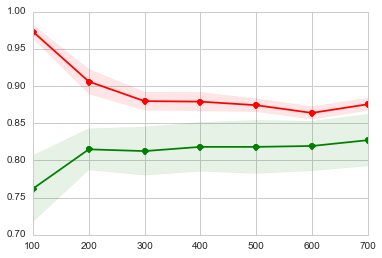

In [208]:
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, 
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Cross-validation score")

### Get csv file

In [178]:
res = grid_search.best_estimator_.predict(test_df)
titanic_file = open('rfm.csv', 'wt')
open_file_object = csv.writer(titanic_file)
open_file_object.writerow(['PassengerId','Survived'])
open_file_object.writerows(zip(ids_test.T, res.T))
titanic_file.close()